# Analyse the tracks

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


56 (56, 4)
Percentage of dismissed MSDs due to bad fit :  20.0  %


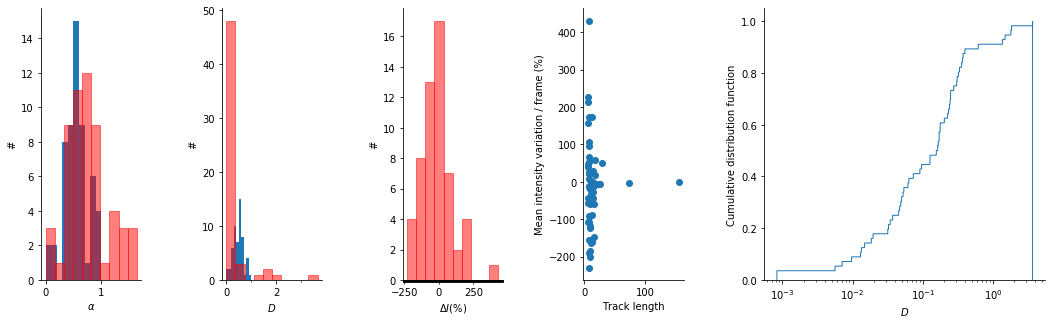

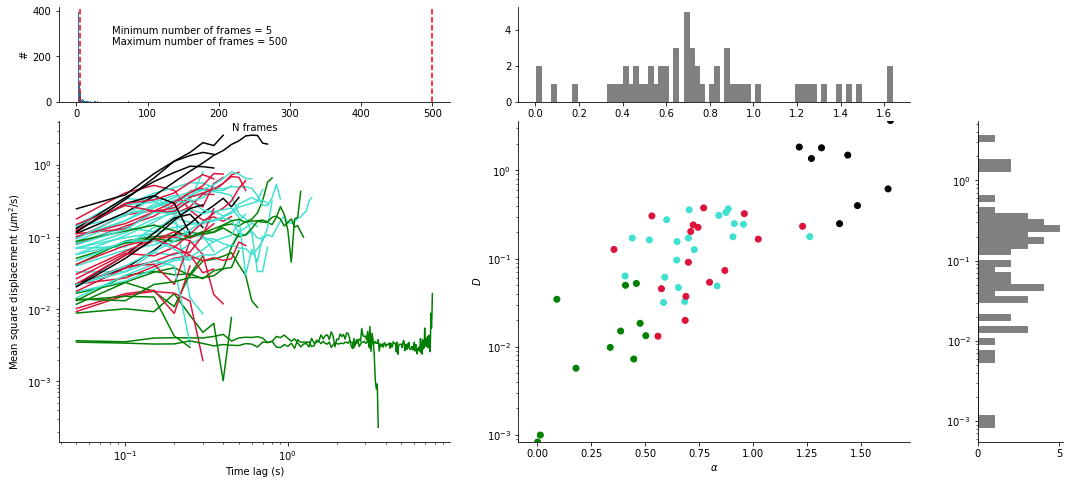

In [22]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function
from scipy.optimize import curve_fit
%matplotlib inline
%reload_ext autoreload

def msd(t, D, alpha):
    """2D MSD: 4*D*t**alpha"""
    return(4*D*t**alpha)

def photobleaching(t,a,A):
    return(A+a*t)

files = ["Data/sm1.csv"]
#files = ['Data/sm1_wnt.csv']
#files = ["Data/sm1.csv","Data/sm2.csv","Data/sm3.csv","Data/sm4.csv","Data/sm5.csv","Data/sm6.csv","Data/sm7.csv","Data/sm8.csv","Data/sm9.csv","Data/sm10.csv","Data/sm11.csv","Data/sm13.csv"]
#files = ["Data/sm1_wnt.csv","Data/sm2_wnt.csv","Data/sm3_wnt.csv","Data/sm4_wnt.csv","Data/sm5_wnt.csv","Data/sm6_wnt.csv","Data/sm7_wnt.csv","Data/sm8_wnt.csv","Data/sm10_wnt.csv","Data/sm11_wnt.csv"]
#Experimental parameters:
dt = 0.05  #time step
minframe = 5
maxframe = 500

frame_alldata = []
minalpha = 1.0E-03
minD = 1.0E-04
maxD = 4
maxalpha = 3

alphaD = []
rhoens_alltracks = []
reduced_linear_data = []
xplot = []
yplot = []


total_tracks=0
anomalous_percentage=0

for filename in files:
    folder_name = filename[5:-4]
    output_folder = "Result/"+folder_name

    data = pd.read_csv(filename) 
    tracklist = data.TRACK_ID.unique()  #list of track ID in data

    for tid in tracklist:

        trackid = data["TRACK_ID"] == tid
        x = data[trackid]["POSITION_X"].to_numpy()   #x associated to track 'tid'
        y = data[trackid]["POSITION_Y"].to_numpy()   #y associated to track 'tid'
        intensity = data[trackid]["MEAN_INTENSITY"].to_numpy()

        frame_alldata.append(len(x))

        rhon = []#list of rho_n for a given track
        if len(x)<maxframe and len(x)>minframe:
            for n in range(1,len(x)):             #for each n = each time lag
                s = 0
                for i in range(0,len(x)-n):
                    s+=(x[n+i] - x[i])**2 + (y[n+i] - y[i])**2
                rhon.append(1/(len(x)-n)*s)         #rho_n = 1/(N-n) * sum_i (r[i+n] - r[i])^2 

            N = len(rhon)+1
            t = [n*dt for n in np.linspace(1,N-1,N-1)]
            t_bleach = [n*dt for n in np.linspace(0,N-1,N)]

            nbrpts = int(0.3*N)
            popt_D, pcov_D = curve_fit(msd, t[:nbrpts+1], rhon[:nbrpts+1])

            #print(len(rhoens_alltracks))
            #plt.plot(rhon)
            #plt.plot(result.best_fit)
            #plt.show()
            popt_I, pcov_I = curve_fit(photobleaching, t_bleach, intensity)
            
            #plt.plot(t_bleach,intensity,label="Experimental data")
            #plt.plot(t_bleach,result_bleach.best_fit,label="Exp fit with a = "+str(round(result_bleach.params['a'].value,4))+" A = "+str(round(result_bleach.params['A'].value,4)))
            #plt.xlabel('time')
            #plt.ylabel('MEAN INTENSITY')
            #plt.legend()
            #plt.savefig("Intensity_SM3/"+str(tid)+".png")
            #plt.show()

            Imean = popt_I[0]
            alpha = popt_D[1]
            D = popt_D[0]
            #print(Imean,alpha,D)

            nuam = 0.01*minalpha
            nuap = 0.01*maxalpha
            nuDm = 0.01*minD
            nuDp = 0.01*maxD

            if 0<alpha and 0<D:
                rhoens_alltracks.append(rhon)
                plot_element = [alpha,D,Imean,len(x)] #len(x)
                alphaD.append(plot_element)

            else:
                anomalous_percentage+=1

            total_tracks+=1


print(len(rhoens_alltracks),np.shape(alphaD))

print("Percentage of dismissed MSDs due to bad fit : ",anomalous_percentage/total_tracks*100," %")

###########################################################
####################COMPUTE K MEAN ########################
###########################################################

from sklearn import cluster, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import preprocessing

k_means = cluster.KMeans(n_clusters=4)
alphaD = np.array(alphaD)

#X_iris = preprocessing.scale(alphaD)
alphaD_positive = np.copy(alphaD)
alphaD_positive[:,2] = [np.abs(l) for l in alphaD_positive[:,2]]

pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_iris = pt.fit_transform(alphaD_positive[:,:3]) #do not use track length for the clustering
#X_iris = preprocessing.normalize(X_iris, norm='l1')
X_iris = preprocessing.minmax_scale(X_iris)

k_means.fit(X_iris)
labels = k_means.labels_

colors = ['g', "k", "crimson", 'turquoise',"pink",'lightcoral','orange','blue']
color_array = []
for k in range(len(labels.astype(np.int))):
    color_index = labels.astype(np.int)[k]
    color_array.append(colors[color_index])

####PLOT PROCESSED DISTRIBUTIONS#########################
plot_preprocessed_dist(X_iris,alphaD)

#########################################################
############## END OF K-MEAN ############################
#########################################################


plot_track_characteristics(dt,alphaD,rhoens_alltracks,frame_alldata,color_array,minframe,maxframe)

#alpha,diff,delta_I = zip(*alphaD)

In [15]:
alpha,diff,delta_I,length = zip(*alphaD)
diff1 = diff

In [17]:
alpha,diff,delta_I,length = zip(*alphaD)
diff2 = diff

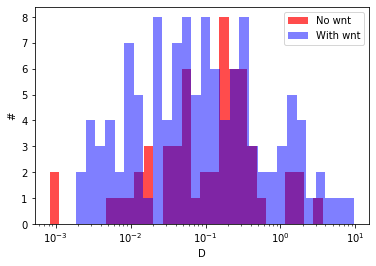

In [21]:
plt.hist(diff1,bins=np.logspace(np.log10(min(diff1)),np.log10(max(diff1)), 30),color='red', alpha=0.7,label="No wnt")
plt.hist(diff2,bins=np.logspace(np.log10(min(diff2)),np.log10(max(diff2)), 30),color='blue', alpha=0.5,label="With wnt")
plt.xscale('log')
plt.xlabel('D')
plt.ylabel('#')
plt.legend()
plt.show()

# Select a cluster to perform linear MSD analysis

In [23]:
clustercolor = input('Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...')

linear_data = []
for k in range(len(color_array)):
    if color_array[k]==clustercolor:
        linear_data.append(rhoens_alltracks[k][:])

reduced_linear_data = np.array(linear_data)

with open('filtered_msd.txt','w') as f:
    for listk in reduced_linear_data:
        for n in range(len(listk)):
            f.write(str(listk[n])+' ')
        f.write('\n')

Over which cluster do you want to perform a linear MSD analysis? Options: g, k, crimson, turquoise, pink, lightcoral...turquoise


29
Use all tracks to compute an ensemble MSD and its associated variance...
Plot ensemble MSD...


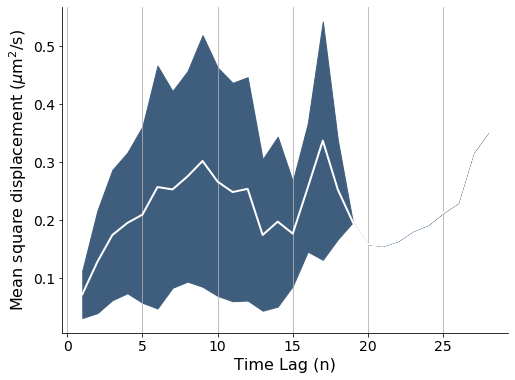

After how many time steps n do you want to cut the data? 8
You have set the cutoff to a time lag of  8  steps...
Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  5  for which the relative error sigma/b =  0.7582454327870085
D =  0.1708
It is estimated that the lowest error will be when the number of fitting points P =  3  for which the relative error sigmaa/a =  0.05432523620795031
sigma =  0.0758
Second run with accurate values for D and sigma.
D =  0.1708
sigma =  0.0758
Done.


In [24]:
from sklearn.linear_model import LinearRegression
from functions import *
import os


data,N_array = MSD_tracks_from_file("filtered_msd.txt")

N = np.shape(data)[1]+1
print(N)
D= 0.2
sigma=0.3
T = N*dt
epsilon = 4*sigma**2
alpha = 4*D*dt

##############" PLOT ALL DATA MSD #################
print("Use all tracks to compute an ensemble MSD and its associated variance...")
msd,var = average(data)
timelagn = np.linspace(1,N-1,N-1)
timelag = [n*dt for n in timelagn]


print("Plot ensemble MSD...")
mmsd_plot(timelagn,msd,var)

### SELECT CUTOFF #################################

data,timelag,msd,var,cutoff = cutoff_function(dt,N,data,timelag,msd,var)

##### PLOT MSD AND VARIANCE WITH CUTOFF ###############

for z in range(2):
    if z==0:
        print("Initial run to determine the best theoretical values for D and sigma.")
    if z==1:
        print("Second run with accurate values for D and sigma.")
    theory_msd = [4*D*n + epsilon for n in timelag]
    theory_variance = THEORETICAL_VARIANCE_2(N_array,sigma,D,dt)[:cutoff]
    cov = COVARIANCE(data,cutoff)
    theory_covariance = THEORETICAL_COVARIANCE_2(N_array,sigma,D,dt,cutoff)#[:cutoff,:cutoff]

    ###########################################
    ############### ERROR SLOPE ###############
    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmab_theory = []
    sigmab_exp_th = []
    sigmab_exp    = []

    for p in Pmin_array:
        sigmab_theory.append(NormMSDSlopeError(N,sigma,D,dt,p))
        sigmab_exp_th.append(NormMSDSlopeError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmab_exp.append(NormMSDSlopeError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmab_exp) 
    min_x = Pmin_array[sigmab_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be for a number of fitting points P = ",min_x," for which the relative error sigma/b = ",min_y)


    timelag = np.array(timelag)
    x = timelag.reshape((-1, 1))
    y = msd
    ctffb = int(min_x)
    model = LinearRegression().fit(x[:ctffb], y[:ctffb])
    r_sq = model.score(x[:ctffb], y[:ctffb])
    fit_b = model.predict(x)

    Dvalue = round(model.coef_[0]/4,4)
    print("D = ",Dvalue)
    Dvalue_error = round(min_y*model.coef_[0]/4,4)


    ###########################################
    ############### ERROR INTERCEPT ###############

    Pmin_array = [int(p) for p in np.linspace(2,cutoff-2,cutoff-3)]
    sigmaa_theory = []
    sigmaa_exp_th = []
    sigmaa_exp    = []
    for p in Pmin_array:
        sigmaa_theory.append(NormMSDInterceptError(N,sigma,D,dt,p))
        sigmaa_exp_th.append(NormMSDInterceptError_exp(N,sigma,D,dt,theory_variance,theory_covariance,p))
        sigmaa_exp.append(NormMSDInterceptError_exp(N,sigma,D,dt,var,cov,p))

    min_y = min(sigmaa_exp) 
    min_x = Pmin_array[sigmaa_exp.index(min_y)]

    if z==0:
        print("It is estimated that the lowest error will be when the number of fitting points P = ",min_x," for which the relative error sigmaa/a = ",min_y)

    timelag = np.array(timelag)
    xa = timelag.reshape((-1, 1))
    ya = msd
    ctffa = int(min_x)
    model = LinearRegression().fit(x[:ctffa], y[:ctffa])
    r_sq = model.score(x[:ctffa], y[:ctffa])
    fit_a = model.predict(x)

    loc_sigma = round(np.sqrt(model.intercept_/4),4)
    loc_sigma_error = round(min_y/2*model.intercept_,4)
    print("sigma = ",loc_sigma)
    
    D = Dvalue
    if np.isnan(loc_sigma)==True:
        print("sigma is nan. Replace with value close to zero.")
        sigma = 0.0000001
    else:
        sigma = loc_sigma

    epsilon = 4*sigma**2
    alpha = 4*D*dt
    if z==1:
        print("Done.")

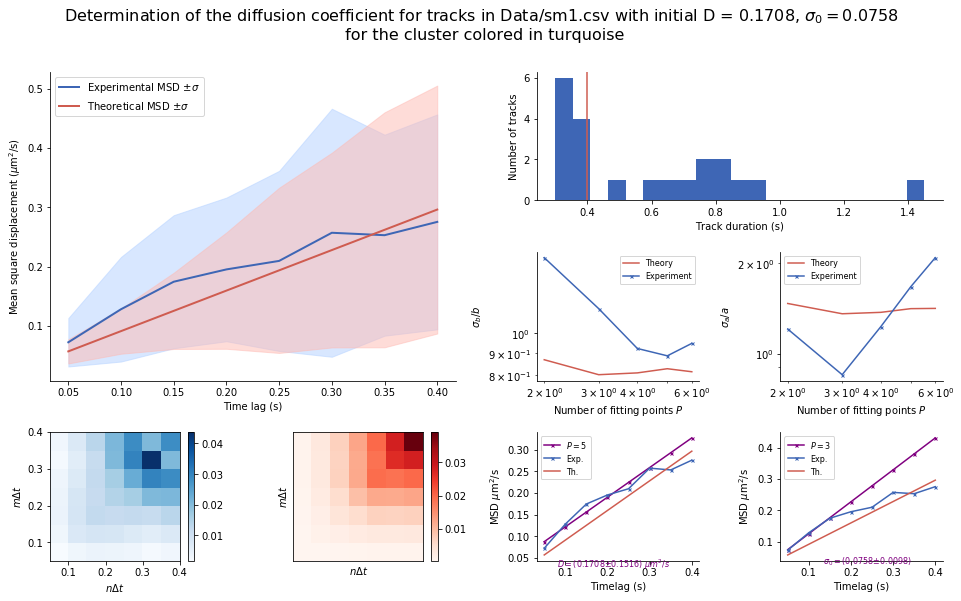

In [25]:
############## GLOBAL PLOT ###################################"

fig = plt.figure(figsize=(16, 9))
grid = plt.GridSpec(3, 4, hspace=0.4, wspace=0.5)
msd_plot = fig.add_subplot(grid[0:2,0:2])
cov_exp = fig.add_subplot(grid[2,0])
cov_th  = fig.add_subplot(grid[2,1])
hist = fig.add_subplot(grid[0,2:4])
sigmab_err = fig.add_subplot(grid[1,2])
sigmaa_err = fig.add_subplot(grid[1,3])
D_plot = fig.add_subplot(grid[2,2])
loc_unc_plot = fig.add_subplot(grid[2,3])

cexp = "#3e66b5"
cth  = "#cf5c50"
msize = 3.0

######## MSD SUBPLOT #######################
msd_plot.spines["top"].set_visible(False)  
msd_plot.spines["right"].set_visible(False)
msd_plot.get_xaxis().tick_bottom()  
msd_plot.get_yaxis().tick_left()
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(msd,var)],[a + np.sqrt(b) for a,b in zip(msd,var)], color="#b3d1ff",alpha=0.5)
msd_plot.fill_between(timelag,[a - np.sqrt(b) for a,b in zip(theory_msd,theory_variance)],[a + np.sqrt(b) for a,b in zip(theory_msd,theory_variance)], color="#febab3",alpha=0.5) 
msd_plot.plot(timelag,msd,color=cexp, lw=2,label="Experimental MSD $\pm \sigma $")
msd_plot.plot(timelag,theory_msd,color=cth, lw=2,label="Theoretical MSD $\pm \sigma $")
msd_plot.set_ylabel(r"Mean square displacement ($\mu$m$^2/$s)",fontsize=10)
msd_plot.set_xlabel('Time lag (s)',fontsize=10)
msd_plot.legend(loc="upper left",fontsize=10)

########## HISTOGRAM ########################"

hist.spines["top"].set_visible(False)  
hist.spines["right"].set_visible(False)
hist.get_xaxis().tick_bottom()  
hist.get_yaxis().tick_left()
hist_array = [n*dt for n in N_array]
hist.hist(hist_array,color=cexp, bins=int(len(N_array)))
hist.axvline(cutoff*dt, 0, max(hist_array),color=cth)
hist.set_xlabel('Track duration (s)',fontsize=10)
hist.set_ylabel('Number of tracks',fontsize=10)

######## COVARIANCE #############################

im1 = cov_exp.pcolormesh(timelag,timelag,cov,cmap="Blues")
cov_exp.set_xlabel(r'$n \Delta t$')
cov_exp.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im1,ax=cov_exp)
#plt.title('Map of experimental covariance values')

im2 = cov_th.pcolormesh(timelag,timelag,theory_covariance,cmap="Reds")
#cov_th.colorbar()
cov_th.set_xticks([])
cov_th.set_yticks([])
cov_th.set_xlabel(r'$n \Delta t$')
cov_th.set_ylabel(r'$m \Delta t$')
cbar = plt.colorbar(im2,ax=cov_th)
#cov_th.set_title('Map of theoretical covariance values')


############## ERRORS ###################################
sigmab_err.spines["top"].set_visible(False)  
sigmab_err.spines["right"].set_visible(False)
sigmab_err.get_xaxis().tick_bottom()  
sigmab_err.get_yaxis().tick_left()
sigmab_err.loglog(Pmin_array,sigmab_exp_th,label="Theory",color=cth)
sigmab_err.loglog(Pmin_array,sigmab_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmab_err.set_xlabel('Number of fitting points $P$')
sigmab_err.set_ylabel(r'$\sigma_b / b$')
sigmab_err.legend(fontsize=8)

sigmaa_err.spines["top"].set_visible(False)  
sigmaa_err.spines["right"].set_visible(False)
sigmaa_err.get_xaxis().tick_bottom()  
sigmaa_err.get_yaxis().tick_left()
sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,label="Theory",color=cth)
#sigmaa_err.loglog(Pmin_array,sigmaa_exp_th,".",label="Control_theory from matrices")
sigmaa_err.loglog(Pmin_array,sigmaa_exp,"-x",label="Experiment",color=cexp,ms=msize)
sigmaa_err.set_xlabel('Number of fitting points $P$')
sigmaa_err.set_ylabel(r'$\sigma_a / a$')
sigmaa_err.legend(fontsize=8)

############" LINEAR FITS ######################################
D_plot.spines["top"].set_visible(False)  
D_plot.spines["right"].set_visible(False)
D_plot.get_xaxis().tick_bottom()  
D_plot.get_yaxis().tick_left()
D_plot.plot(x, fit_b,"-x",label=r'$P = $'+str(ctffb),color="purple",ms=msize)
D_plot.plot(timelag,msd,"-x",label="Exp.",color=cexp,ms=msize)
D_plot.plot(timelag,theory_msd,label="Th.",color=cth)
D_plot.legend(loc="upper left",fontsize=8)
D_plot.set_xlabel('Timelag (s)')
D_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
D_plot.text(max(timelag)/5,max(msd)/10,r'$D = ($'+str(Dvalue)+"$\pm$"+str(Dvalue_error)+") $\mu m^2 / s$",color="purple",fontsize=8)

loc_unc_plot.spines["top"].set_visible(False)  
loc_unc_plot.spines["right"].set_visible(False)
loc_unc_plot.get_xaxis().tick_bottom()  
loc_unc_plot.get_yaxis().tick_left()
loc_unc_plot.plot(x, fit_a,"-x",label=r'$P = $'+str(ctffa),color="purple",ms=msize)
loc_unc_plot.plot(timelag,msd,"x-",label="Exp.",color=cexp,ms=msize)
loc_unc_plot.plot(timelag,theory_msd,label="Th.",color=cth)
loc_unc_plot.legend(loc="upper left",fontsize=8)
loc_unc_plot.set_xlabel('Timelag (s)')
loc_unc_plot.set_ylabel(r'MSD $\mu$m$^2/$s')
loc_unc_plot.text(max(timelag)/3,max(msd)/10,r'$\sigma_0 = ($'+str(loc_sigma)+"$\pm$"+str(loc_sigma_error)+")",color="purple",fontsize=8)

fig.suptitle(r'Determination of the diffusion coefficient for tracks in '+filename+" with initial D = "+str(D)+", $\sigma_0 = $"+str(sigma)+"\n for the cluster colored in "+clustercolor, fontsize=16)
#plt.savefig(output_folder+'/graphs.png')
plt.show()